In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import pathlib
import os
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import joblib

In [2]:
def feature_extraction(img_in, mask):
    feature = {'mean_0': [],
               'mean_1': [],
               'mean_2': [],
               'median_0': [],
               'median_1': [],
               'median_2': [],
              }
    
    feature['mean_0'].append(int(np.mean(img_in[:, :, 0][mask == 0])))
    feature['mean_1'].append(int(np.mean(img_in[:, :, 1][mask == 0])))
    feature['mean_2'].append(int(np.mean(img_in[:, :, 2][mask == 0])))
    feature['median_0'].append(int(np.median(img_in[:, :, 0][mask == 0])))
    feature['median_1'].append(int(np.median(img_in[:, :, 1][mask == 0])))
    feature['median_2'].append(int(np.median(img_in[:, :, 2][mask == 0])))

    df = pd.DataFrame.from_dict(feature)
    
    return df

In [3]:
def histogram_equalization(img_in):

    # segregate color streams
    b, g, r = cv2.split(img_in)
    h_b, _ = np.histogram(b, 256, [0, 256])
    h_g, _ = np.histogram(g, 256, [0, 256])
    h_r, _ = np.histogram(r, 256, [0, 256])

    # Cumulative distribution function
    cdf_b = np.cumsum(h_b)
    cdf_g = np.cumsum(h_g)
    cdf_r = np.cumsum(h_r)

    # Normalize the cumulative distribution function
    cdf_norm_b = np.ma.masked_equal(cdf_b, 0)
    cdf_norm_b = ((cdf_norm_b - cdf_norm_b.min()) * 255 / (cdf_norm_b.max() - cdf_norm_b.min()))
    cdf_final_b = np.ma.filled(cdf_norm_b, 0).astype("uint8")
    cdf_norm_g = np.ma.masked_equal(cdf_g, 0)
    cdf_norm_g = ((cdf_norm_g - cdf_norm_g.min()) * 255 / (cdf_norm_g.max() - cdf_norm_g.min()))
    cdf_final_g = np.ma.filled(cdf_norm_g, 0).astype("uint8")
    cdf_norm_r = np.ma.masked_equal(cdf_r, 0)
    cdf_norm_r = ((cdf_norm_r - cdf_norm_r.min()) * 255 / (cdf_norm_r.max() - cdf_norm_r.min()))
    cdf_final_r = np.ma.filled(cdf_norm_r, 0).astype("uint8")
    
    # merge the images in the three channels
    img_b = cdf_final_b[b]
    img_g = cdf_final_g[g]
    img_r = cdf_final_r[r]
    img_out = cv2.merge((img_b, img_g, img_r))
    return img_out

In [4]:
def sharpening(img_in):
    kernel = np.array([[-1, -1, -1], [-1, 9, -1], [-1, -1, -1]])
    sharpened = cv2.filter2D(img_in, -1, kernel)
    return sharpened

In [5]:
def remove_background(img_in):
    img_edge, significant = segmentation_by_edge(img_in)
    mask = img_edge.copy()
    mask[mask > 0] = 0
    cv2.fillPoly(mask, significant, 255)
    mask = np.logical_not(mask)
    img_in[mask] = 255
    return img_in, mask

In [6]:
def segmentation_by_edge(img_in):
    # step1: remove noise
    img = cv2.GaussianBlur(img_in, (5, 5), 0)
    
    # step2: edge detection
    # finding the max intesity from among the R,G and B edges. img_edge = np.max(
    img_edge = np.max(np.array([
            edge_detection(img[:, :, 0]),
            edge_detection(img[:, :, 1]),
            edge_detection(img[:, :, 2]),
        ]),axis = 0,)
    
    # step3: Remove the false edge
    mean = np.mean(img_edge)
    img_edge[img_edge <= mean * 1.5] = 0
    # step4 , step5 : Loss of rupture and find contours
    img_edge = np.asarray(img_edge, np.uint8)
    contours, heirarchy = cv2.findContours(img_edge, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    contours_level1 = []
    for i, tupl in enumerate(heirarchy[0]):
        if tupl[3] == -1:
            tupl = np.insert(tupl, 0, [i])
            contours_level1.append(tupl)
    contours_significant = []
    contors_tooSmall = img_edge.size * 5 / 100
    for tupl in contours_level1:
        contour = contours[tupl[0]]
        area = cv2.contourArea(contour)
        if area > contors_tooSmall:
            contours_significant.append([contour, area])
            cv2.drawContours(img, [contour], 0, (0, 255, 0), 2, cv2.LINE_AA, maxLevel=1)
    contours_significant.sort(key=lambda x: x[1])
    significant = [x[0] for x in contours_significant]
    return (img_edge, significant)

In [7]:
def edge_detection(channel):
    sobelX = cv2.Sobel(channel, cv2.CV_16S, 1, 0)
    sobelY = cv2.Sobel(channel, cv2.CV_16S, 0, 1)
    sobel = np.hypot(sobelX, sobelY)
    sobel[sobel > 255] = 255
    return sobel    

True

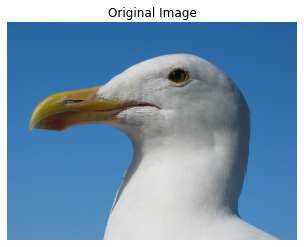

In [41]:
# image_path = 'dataset/True/36.jpg'
image_path = 'dataset/False/10.jpeg'

image = cv2.imread(image_path)
path = os.path.join('result', pathlib.Path(image_path).name)
isExist = os.path.exists(path)
if not isExist:
    os.mkdir(path)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
plt.axis("off")
cv2.imwrite(os.path.join(path,'main_image.png'),image)

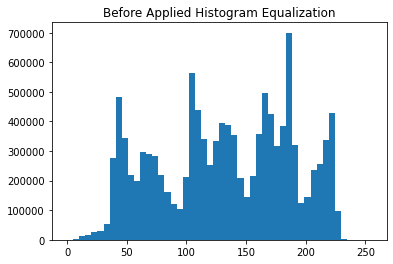

In [42]:
img = np.asarray(image)
flat = img.flatten()

plt.hist(flat, bins=50)
plt.title("Before Applied Histogram Equalization")
plt.savefig(os.path.join(path,'hist_before.png'))

True

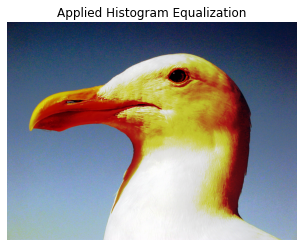

In [43]:
img_out = histogram_equalization(image)

plt.imshow(cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB))
plt.title("Applied Histogram Equalization")
plt.axis("off")
cv2.imwrite(os.path.join(path,'histogram_equalization.png'),img_out)

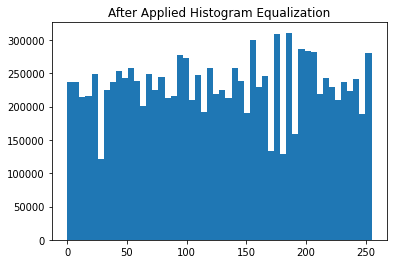

In [44]:
flat = img_out.flatten()
plt.hist(flat, bins=50)
plt.title("After Applied Histogram Equalization")
plt.savefig(os.path.join(path,'hist_after.png'))

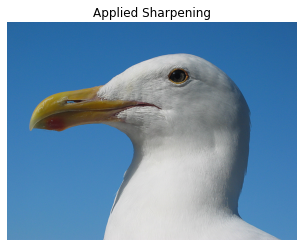

In [45]:
img_out = sharpening(image)
plt.imshow(cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB))
plt.title("Applied Sharpening")
plt.axis("off")
plt.savefig(os.path.join(path,'sharpening.png'))

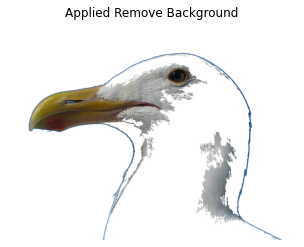

In [46]:
img_out, mask = remove_background(image)
plt.imshow(cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB))
plt.title("Applied Remove Background")
plt.axis("off")
plt.savefig(os.path.join(path,'remove_background.png'))

In [47]:
X_test = feature_extraction(img_out, mask)
X_test

,mean_0,mean_1,mean_2,median_0,median_1,median_2
0,116,126,129,136,135,137


In [48]:
loaded_model = joblib.load('model/finalized_model.sav')
y_pred = loaded_model.predict(X_test)
y_pred

array([0])